In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)

import numpy as np


from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score


import seaborn as sns
import matplotlib.pyplot as plt





In [2]:
data = pd.read_csv('final_wec_data.csv')

/tmp/ipykernel_3941/3317488320.py:1: DtypeWarning: Columns (26,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('final_wec_data.csv')


In [3]:
def df_for_ml(df):

    df = df.drop('Unnamed: 0', axis=1)
    df = data[data['year'] >= 2017].reset_index(drop=True)
    # Dropping data from prior to 2017 as driver_ratings data was not available
    df = df.drop(['lap_number', 'car_number', 'lap_number', 'driver_number', 'lap_time', 'elapsed', 'hour', 's1_large', 's2_large', 's3_large', 'driver_name', 'pit_time', 'group', 'team', 'manufacturer', 'season', 'vehicle', 'team_no','lap_time_ms', 'engine', 'driver_stint',
           'team_stint', 'team_stint_no', 'interval_ms', 'interval', 'elapsed_ms', 'position', 'gap', 'elapsed_s'], axis=1)
    # Initial columns dropped because not needed/not useable for modeling. Remaining columns will be further assessed 
    
    return df




In [4]:
data = df_for_ml(data)

In [5]:
def fixing_kept_cols(df):

    df = df[df['class']!='INNOVATIVE CAR']
#     removing the innovative class to eliminate outlier data
    
    df = df[df['crossing_finish_line_in_pit']==0]
#     Filtering out rows where the lap ended in the pit lane (commonly known as an in-lap). 
# In theory this data could be useful for the model, under normal circumstances an in-lap would be run on old tires. A driver who can run a faster in-lap than their rivals
# may be able to gain positions or time on a competitor and thus suggested a more skilled driver. However a car that has had an issue on track will have an abnormally slow in-lap as it limps back to the pitlane.
# The in-lap data complicates the process of trimming outliers from the lap time data. Since only ~6% of records were in-laps we will simply drop these records
    
    df = df.dropna().reset_index(drop=True)
#    Dropping any rows with missing values in remaining data

    return df



In [6]:
data = fixing_kept_cols(data)

In [7]:

def trim_outliers(df):
    grouped = df.groupby(['class', 'circuit'])
    for key, group in grouped:
        IQR = np.percentile(group['lap_time_s'], 75) - np.percentile(group['lap_time_s'], 25)
        u_limit = np.percentile(group['lap_time_s'], 75) + 1*IQR
#         l_limit = np.percentile(group['lap_time_s'], 25) - 1.5*IQR
#         print(key, 'IQR: ', IQR, 'u_lim: ', u_limit, 'l_lim: ', l_limit)
        group = group[group['lap_time_s'] < u_limit]
        if 'new_df' in locals():
            new_df = pd.concat([new_df, group])
        else:
            new_df = group.reset_index(drop=True)
        
    return new_df

# Common practice is to remove records based on both the upper and lower limits. Given the type of data we're dealing with it makes sense to only trim upper-limit outliers
# This will remove laps where a car crashed, broke down, or was otherwise delayed on track. This will also serve to remove laps run under slowzones, FCY, or Safety car procedures since we do not have data to indicate those situations.
#The removed print statement would show the IQR and limit values for each circuit/class pairing for checking

In [8]:
data = trim_outliers(data)

In [9]:
def separate_df(df):
    cont_nums = df.select_dtypes('number')
    cont_nums = cont_nums.drop(['lap_improvement', 'crossing_finish_line_in_pit', 's1_improvement', 's2_improvement', 's3_improvement', 'year', 'round', 'driver_stint_no', 'class_position'], axis=1)
    
    disc_nums = df[['lap_improvement', 'crossing_finish_line_in_pit', 's1_improvement', 's2_improvement', 's3_improvement', 'year', 'round', 'driver_stint_no', 'class_position']]
    
    obs = data.select_dtypes(object).drop('rating', axis=1)

    
    
    
    target = df['rating']
    
    return cont_nums, disc_nums, obs, target

In [10]:
cont_nums, disc_nums, obs, target = separate_df(data)

In [11]:
def encode_obs(obs):
    class_one_hot = pd.get_dummies(obs['class'], prefix='class')
    circuit_one_hot = pd.get_dummies(obs['circuit'], prefix='circuit')
    
    ob_feats = pd.concat([class_one_hot, circuit_one_hot], axis=1)
    
    return ob_feats


In [12]:
ob_feats = encode_obs(obs)

In [13]:
def make_scaled_sets(df):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
    
    scales = []
    
    s_scaler = StandardScaler()
    num_s_scal = s_scaler.fit_transform(df)
    num_s_scal = pd.DataFrame(num_s_scal)
    num_s_scal.columns = num_s_scal.columns.astype(str)
    num_s_scal.name = 'StandardScaler'
    scales.append(num_s_scal)
    
    mm_scaler = MinMaxScaler()
    num_mm_scal = mm_scaler.fit_transform(df)
    num_mm_scal = pd.DataFrame(num_mm_scal)
    num_mm_scal.columns = num_mm_scal.columns.astype(str)
    num_mm_scal.name = 'MinMaxScaler'
    scales.append(num_mm_scal)
    
    abs_scaler = MaxAbsScaler()
    num_abs_scal = abs_scaler.fit_transform(df)
    num_abs_scal = pd.DataFrame(num_abs_scal)
    num_abs_scal.columns = num_abs_scal.columns.astype(str)
    num_abs_scal.name = 'MaxAbsScaler'
    scales.append(num_abs_scal)
    
    
    return scales



In [14]:
scales = make_scaled_sets(cont_nums)


In [15]:
disc_nums = disc_nums.reset_index(drop=True)
ob_feats = ob_feats.reset_index(drop=True)


In [16]:

features = pd.concat([scales[0], disc_nums, ob_feats], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 55)
# # Concatenating features and Making a split for initial testing purposes.

In [17]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Training/fitting an initial run of the RandomForest Classifiier for baseline testing and for parameter tuning

# Initial model run resulted in decent accuracy but we will use Hyperparameter tuning to improve the result.

Accuracy: 0.8952385275293904


In [18]:
def hyper_tuning_rfc(X_train, y_train):
    param_grid_rfc = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']}
    rfc = RandomForestClassifier()
    grid_search = GridSearchCV(rfc, param_grid=param_grid_rfc, cv=5)
    grid_search.fit(X_train, y_train)
    rfc_best_params = grid_search.best_params_
    
    
    #print the best parameters and score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    return rfc_best_params

# # Running multiple loops of the model to find the optimal set of model parameters to maximize model accuracy.
# # Using the GridSearchCV function will allow us to test multiple iterations of the model each with a different set of parameters. The function compares the accuracy score of each iteration
# # and will finally report the best score and the parameter settings used to acheive this. 




In [19]:
 rfc_best_params = hyper_tuning_rfc(X_train, y_train)

Best parameters:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score:  0.8054332829152779


In [20]:

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# # An initial run of the KNN Classifier on the same training data as the RandomForest model reports much higher accuracy

# # Hyper-paramter tuning will be run for this model as well in an attempt to maximize our models accuracy.

Accuracy: 0.8300349507512143


In [21]:
def hyper_tuning_knn(X_train, y_train):
    param_grid_knn = {'n_neighbors': (1,10, 1), 'leaf_size': (20,40,1), 'p': (1,2), 'weights': ('uniform', 'distance'), 'metric': ('minkowski', 'chebyshev')}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)
    grid_search.fit(X_train, y_train)
    knn_best_params = grid_search.best_params_
    
    
    #print the best parameters and score
    print("Best parameters: ", grid_search.best_params_)
    print("Best score: ", grid_search.best_score_)

    return knn_best_params

# # Running multiple loops of the model to find the optimal set of model parameters to maximize model accuracy

# # ***After running the grid search function through the model hyperparameters we have acheived a best score of ~84% accuracy. The output best parameters wil be used for this model from here on out. 


In [44]:
knn_best_params = hyper_tuning_knn(X_train, y_train)

Best parameters:  {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Best score:  0.8907070247316268


In [23]:
models = [RandomForestClassifier(), KNeighborsClassifier()]

In [24]:
def test_models_scales(scales, disc_nums, ob_feats, models, knn_best_params, rfc_best_params, target):
    for model in models:
        model_name = type(model).__name__
        for scale in scales:
            scale_name = scale.name
            features = pd.concat([scale, disc_nums, ob_feats], axis=1)
            X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=55)
            if model_name == 'KNeighborsClassifier':
                clf = KNeighborsClassifier(**knn_best_params)
            elif model_name == 'RandomForestClassifier':
                clf = RandomForestClassifier(**rfc_best_params)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"{model_name} : {scale_name} : {accuracy}")


In [25]:
test_models_scales(scales, disc_nums, ob_feats, models, knn_best_params, rfc_best_params, target)

RandomForestClassifier : StandardScaler : 0.8123326222141528
RandomForestClassifier : MinMaxScaler : 0.8143978938768099
RandomForestClassifier : MaxAbsScaler : 0.8158730879215651
KNeighborsClassifier : StandardScaler : 0.9021152013072489
KNeighborsClassifier : MinMaxScaler : 0.8873632608596977
KNeighborsClassifier : MaxAbsScaler : 0.8872270891017203


SyntaxError: invalid syntax (2145362141.py, line 1)

In [47]:

features = pd.concat([scales[0], disc_nums, ob_feats], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=55)
driver_ratings_model = KNeighborsClassifier(**knn_best_params)
driver_ratings_model.fit(X_train, y_train)

y_pred = driver_ratings_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9021152013072489


In [48]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           B       0.91      0.93      0.92      5621
           G       0.86      0.85      0.86      9431
           P       0.94      0.94      0.94     20297
           S       0.86      0.86      0.86      8713

    accuracy                           0.90     44062
   macro avg       0.89      0.89      0.89     44062
weighted avg       0.90      0.90      0.90     44062



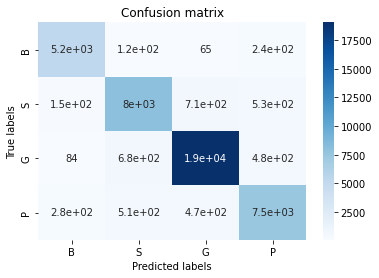

In [49]:



cm = confusion_matrix(y_test, y_pred)
class_names = ['B', 'S', 'G', 'P']  # Setting the asxis laels for the heatmap

# Ploting the confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [50]:
# With the reults from the test_models_scales function we now have the optimal model type, scaler type, and best parameters for the model.
# Now we can fit the model one last time to export for future use.



import joblib
   
# Save the model as a pickle in a file
joblib.dump(driver_ratings_model, 'driver_ratings_model.pkl')
  

['driver_ratings_model.pkl']